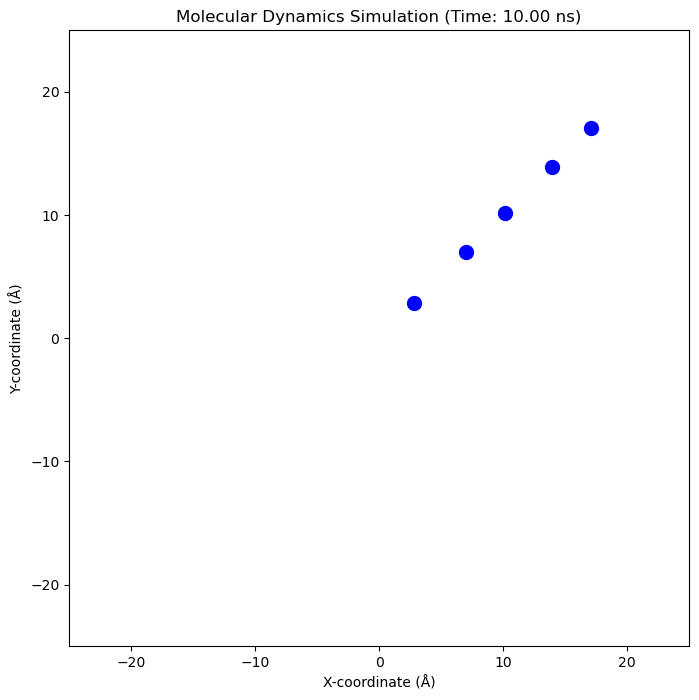

In [4]:
""" Molecular Dynamics Simulation (Object-Oriented Version)
This code simulates the dynamics of atoms governed by the Lennard-Jones potential at the molecular scale.
Authors: Borui Xu, Lucien Tsai, Yeqi Chu
"""

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

class Atom:
    """Class representing an individual atom in the simulation."""
    def __init__(self, position, velocity, mass, epsilon, sigma):
        self.position = np.array(position, dtype=float)
        self.velocity = np.array(velocity, dtype=float)
        self.mass = mass
        self.epsilon = epsilon
        self.sigma = sigma
        self.force = np.zeros(3, dtype=float)

class MolecularDynamicsSimulator:
    """Class for simulating molecular dynamics using the Lennard-Jones potential."""
    def __init__(self, atoms, box_size, total_time, total_steps):
        self.atoms = atoms
        self.box_size = box_size
        self.total_time = total_time
        self.total_steps = total_steps
        self.dt = total_time / total_steps
        self.num_atoms = len(atoms)
        self.positions = np.zeros((total_steps + 1, self.num_atoms, 3))
        self.velocities = np.zeros((total_steps + 1, self.num_atoms, 3))

    def compute_forces(self):
        """Compute forces on all atoms."""
        for atom in self.atoms:
            atom.force.fill(0.0)

        for i in range(self.num_atoms):
            atom_i = self.atoms[i]
            for j in range(i + 1, self.num_atoms):
                atom_j = self.atoms[j]
                # Compute distance vector and magnitude
                delta = atom_i.position - atom_j.position
                # Apply minimum image convention for periodic boundaries
                delta -= self.box_size * np.round(delta / self.box_size)
                r = np.linalg.norm(delta)
                if r == 0:
                    continue  # Avoid division by zero
                # Compute Lennard-Jones parameters
                epsilon_ij = np.sqrt(atom_i.epsilon * atom_j.epsilon)
                sigma_ij = (atom_i.sigma + atom_j.sigma) / 2
                # Compute force magnitude
                F_mag = 4 * epsilon_ij * (
                    (12 * sigma_ij ** 12 / r ** 13) - (6 * sigma_ij ** 6 / r ** 7)
                )
                # Update forces
                force_vector = (F_mag / r) * delta
                atom_i.force += force_vector
                atom_j.force -= force_vector  # Newton's third law

    def integrate(self):
        """Perform the Verlet integration over all time steps."""
        # Initialize positions and velocities
        for idx, atom in enumerate(self.atoms):
            self.positions[0, idx, :] = atom.position
            self.velocities[0, idx, :] = atom.velocity

        # Compute initial forces
        self.compute_forces()

        # Time integration loop
        for step in range(1, self.total_steps + 1):
            for idx, atom in enumerate(self.atoms):
                # Update positions
                atom.position += atom.velocity * self.dt + (atom.force / (2 * atom.mass)) * self.dt ** 2
                # Apply periodic boundary conditions
                atom.position %= self.box_size

            # Compute new forces
            self.compute_forces()

            for idx, atom in enumerate(self.atoms):
                # Update velocities
                atom.velocity += (atom.force / atom.mass) * self.dt
                # Store positions and velocities
                self.positions[step, idx, :] = atom.position
                self.velocities[step, idx, :] = atom.velocity

    def animate(self, filename='md_simulation.gif', interval=50, save_gif=True):
        """Create and optionally save an animation of the simulation."""
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xlim(-self.box_size, self.box_size)
        ax.set_ylim(-self.box_size, self.box_size)
        ax.set_xlabel('X-coordinate (Å)')
        ax.set_ylabel('Y-coordinate (Å)')
        ax.set_title('Molecular Dynamics Simulation')
        scat = ax.scatter([], [], s=100)

        def update(frame):
            ax.clear()
            ax.set_xlim(-self.box_size, self.box_size)
            ax.set_ylim(-self.box_size, self.box_size)
            ax.set_xlabel('X-coordinate (Å)')
            ax.set_ylabel('Y-coordinate (Å)')
            ax.set_title(f'Molecular Dynamics Simulation (Time: {frame * self.dt:.2f} ns)')
            positions = self.positions[frame]
            scat = ax.scatter(positions[:, 0], positions[:, 1], s=100, c='blue')
            return scat,

        ani = FuncAnimation(fig, update, frames=range(0, self.total_steps + 1, 10), interval=interval, blit=True)

        if save_gif:
            ani.save(filename, writer='pillow', fps=20)
        plt.show()

# Simulation parameters
box_size = 25.0  # Units in Å
total_time = 10.0  # Units in ns
total_steps = 1000

# Create atoms
atoms = []
positions = [
    [1, 1, 1],
    [5, 5, 1],
    [10, 10, 1],
    [15, 15, 1],
    [20, 20, 1]
]
velocities = [
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0]
]
mass = 1.0  # Units in AMU
epsilon = 2.0  # Units in eV
sigma = 4.0  # Units in Å

for pos, vel in zip(positions, velocities):
    atom = Atom(position=pos, velocity=vel, mass=mass, epsilon=epsilon, sigma=sigma)
    atoms.append(atom)

# Create simulator instance
simulator = MolecularDynamicsSimulator(atoms, box_size, total_time, total_steps)

# Run simulation
simulator.integrate()

# Animate the results
simulator.animate()